# A2C - CartPole Agent

This is an implementation of an _Advantage Actor-Critic method_ for solving the CartPole environment in OpenAI gym. Resource for this one is [the RLcode repo](https://github.com/rlcode/reinforcement-learning/blob/master/2-cartpole/4-actor-critic/cartpole_a2c.py). This is created so that we can see how to code an A2C agent and learn the basics first on what the general idea for the architecture is before applying it to more complex tasks.

In [1]:
'''
NOTE:
This is an implementation of the Advantage actor-critic agent for Cartpole.
The main source for this one would be in this repo: https://github.com/rlcode/reinforcement-learning/blob/master/2-cartpole/4-actor-critic/cartpole_a2c.py
This was done by rlcode guys, similar to the one that gave us DQN-Cartpole earlier.
'''

# Import dependencies

import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

C:\Users\icfernando\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


For the next step we will create the agent that we will be using. It will contain the functions for creating the model for both actor and critic. It will also include the function for the training as well as the function for getting the action.

In [16]:
#NOTE: Start of the Cartpole Agent using A2C (Advantage Actor-Critic)
class A2CAgent:
    def __init__(self, state_size, action_size,nodes):
        self.render = False # For rendering the cartpole model
        self.load_model = False # Set if you want to load a previous checkpoint
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.nodes = nodes

        # Policy Gradient hyperparameters
        # NOTE: Read more on Policy Gradient

        self.discount_factor = 0.99 # For the entire update statement
        self.actor_lr = 0.001 # For the Optimizer of Actor
        self.critic_lr = 0.005 # Why is it higher? For stability?

        # Call the building blocks
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        # Check if we need to load a model
        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")
    # We then create the Neural Network for the approximation of the actor and critic values
    # i.e. policy and value for the model.

    # NOTE: Actor module: Input of states and outputs the probability of an action (softmax)
    def build_actor(self):
        actor = Sequential() # Define our model
        actor.add(Dense(self.nodes , input_dim = self.state_size, activation= 'relu', kernel_initializer= 'he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',kernel_initializer='he_uniform'))
        actor.summary()
        actor.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = self.actor_lr))
        return actor
    # NOTE: Critic module: Input is also state but the output is also state(linear)
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(self.nodes, input_dim = self.state_size, activation= 'relu', kernel_initializer= 'he_uniform'))
        critic.add(Dense(self.value_size,activation= 'linear', kernel_initializer= 'he_uniform'))
        critic.summary()
        critic.compile(loss = 'mse', optimizer= Adam(lr=self.critic_lr))# Loss is MSE since we want to give out a value and not a probability.
        return critic
    # NOTE: We do the function on how the agent will pick the next action and policy based on stochastics(probability)
    def get_action(self,state):
        policy = self.actor.predict(state,batch_size=1).flatten()
        return np.random.choice(self.action_size,1,p=policy)[0]
    # NOTE: We do the update for the network policy.
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1,self.value_size)) # Initialize the policy targets matrix
        advantages = np.zeros((1,self.action_size)) # Initialize the advantages matrix

        value = self.critic.predict(state)[0] # Get value for this state
        next_value = self.critic.predict(next_state)[0] # Get value for the next state

        # update the advantages and value tables if done
        if done:
            advantages[0][action] = reward - value # Basically, what do we gain by choosing the action, will it improve or worsen the advantage
            target[0][0] = reward # Fill in the target value to see if we can still improve it in the policy making
        else:
            advantages[0][action] = reward + self.discount_factor*(next_value) - value # If not yet done, then simply update for the current step.
            target[0][0] = reward + self.discount_factor*next_value
        # Once we are done with the episode, we then update the weights
        self.actor.fit(state,advantages,epochs=1,verbose=0)
        self.critic.fit(state,target,epochs=1,verbose=0)

Fir the next section, we are creating a class for our training module. In the original source, this was simply run as is but in my case I wanted to reuse it to experiment on the effects of the number of nodes. We can actually edit this class so that you can specify everything for the agent like the lr for the actor and the critic, the discount factor as well. Also, you can actually define how many episodes you might want to train.

In [29]:
class A2C_train:
    def __init__(self, episodes,nodes):
        self.Episodes = episodes
        self.nodes = nodes
        if __name__ == '__main__':
            # TODO: Create an environment
            env = gym.make('CartPole-v1')
            # TODO: Get the action and state sizes
            state_size = env.observation_space.shape[0]
            action_size = env.action_space.n
            # TODO: Make the agent by calling the function earlier
            agent = A2CAgent(state_size,action_size,self.nodes)
            # TODO: Initialize our scores and episodes list
            scores, episodes = [], []

            # TODO: Create the training loop
            for e in range(self.Episodes):
                done = False
                score = 0
                state = env.reset()
                state = np.reshape(state,[1,state_size])

                while not done:
                    # Check if we want to render
                    if agent.render:
                        env.render()
                    action = agent.get_action(state)
                    next_state, reward, done, info = env.step(action)
                    next_state = np.reshape(next_state,[1,state_size])
                    # Give immediate penalty for an action that terminates the episode immediately, Since we want to maximize the time
                    # Note that the max for the cartpole is 499 and it will reset, otherwise we keep the current score if it is not yet done, and if it ended we give a -100 reward
                    reward = reward if not done or score == 499 else -100
                    # We now train the model based on the results of our action taken
                    agent.train_model(state,action,reward,next_state,done)
                    score += reward
                    state = next_state

                    if done:
                        score = score if score == 500.0 else score +100
                        scores.append(score)
                        episodes.append(e)
                        pylab.plot(episodes,scores,'b')
                        pylab.savefig("./save_graph/A2C-CartPole.png")
                        if np.mean(scores[-min(10, len(scores)):]) > 490:
                            sys.exit()
                if e % 50 ==0:
                    agent.actor.save_weights("./save_model/cartpole_actor.h5")
                    agent.critic.save_weights("./save_model/cartpole_critic.h5")   
                    print("episode: {} score: {}".format(e,score))

## Results

For the next sections we just check the results of the agent from the original 24 nodes, a very small 8 nodes and a very large 64 node NN. For the results, we refer to the original 24 node agent as the baseline. Note: I ran the original notebook at 1000 episodes but for this one it is set at 250 just to show that the model does train.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 25        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
episode: 0 score: 24.0
episode: 50 score: 17.0
episode: 100 score: 50.0
episode:

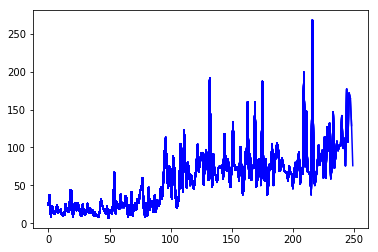

In [31]:
A2C_train(250,24)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 18        
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 9         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
episode: 0 score: 23.0
episode: 50 score: 16.0
episode: 100 score: 9.0
episode: 150 

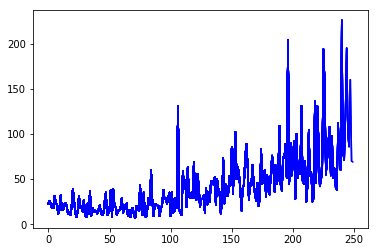

In [33]:
A2C_train(250,8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 130       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
episode: 0 score: 15.0
episode: 50 score: 32.0
episode: 100 score: 75.0
episode:

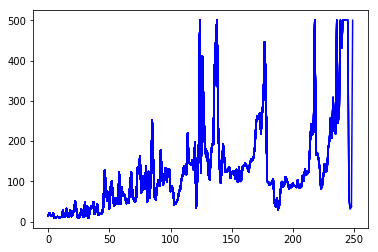

In [32]:
A2C_train(250,64)

Note that the runtime for the 8 node agent will be quite long compared to the original 24 node agent. For the 64 node agent, it is also long. In theory it should be much longer than the 8 node but it does make up for it in the fact that it can actually get to the solution faster and be able to remember it. This is based on the graph results. If we look at the 24 node we can see the volatility although the trend is still increasing. For the 64 node, we can already see it peaking and maintaining it for some runs. While for the 8 node, it is just noisy and the trend is rather flat. The question now is why is it that the agent still gets erratic behaviour instead of a general solution? That is because we are using a stochastic approach for the implementation. If you look at the code, we used random choice with probability set as the policy. We are non-deterministic in a sense that we do not hardcode our policy so there will always be a time where our agent will try to do a weird move. This is in line with the exploration vs. exploitation method.